<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Examples/blob/master/notebooks/lung_nodules_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Tutorial

The purpose of this tutorial is to educate users on: 

* how to select, access, and download cohorts from IDC;
* what are some of the tools that can be used to get the DICOM data ready for your favourite imaging analysis pipelines;
* how to run an end-to-end pipeline and visualise the final results exploiting the Google Cloud Computing (GCP) and IDC platform.

**To access the resources needed for this tutorial, you will need to be registered on the IDC platform.**

If you are not yet registered, [sign up at this link](https://portal.imaging.datacommons.cancer.gov/accounts/signup/) or simply make sure you can [sign in at the IDC portal via your Google account](https://portal.imaging.datacommons.cancer.gov/accounts/login/)




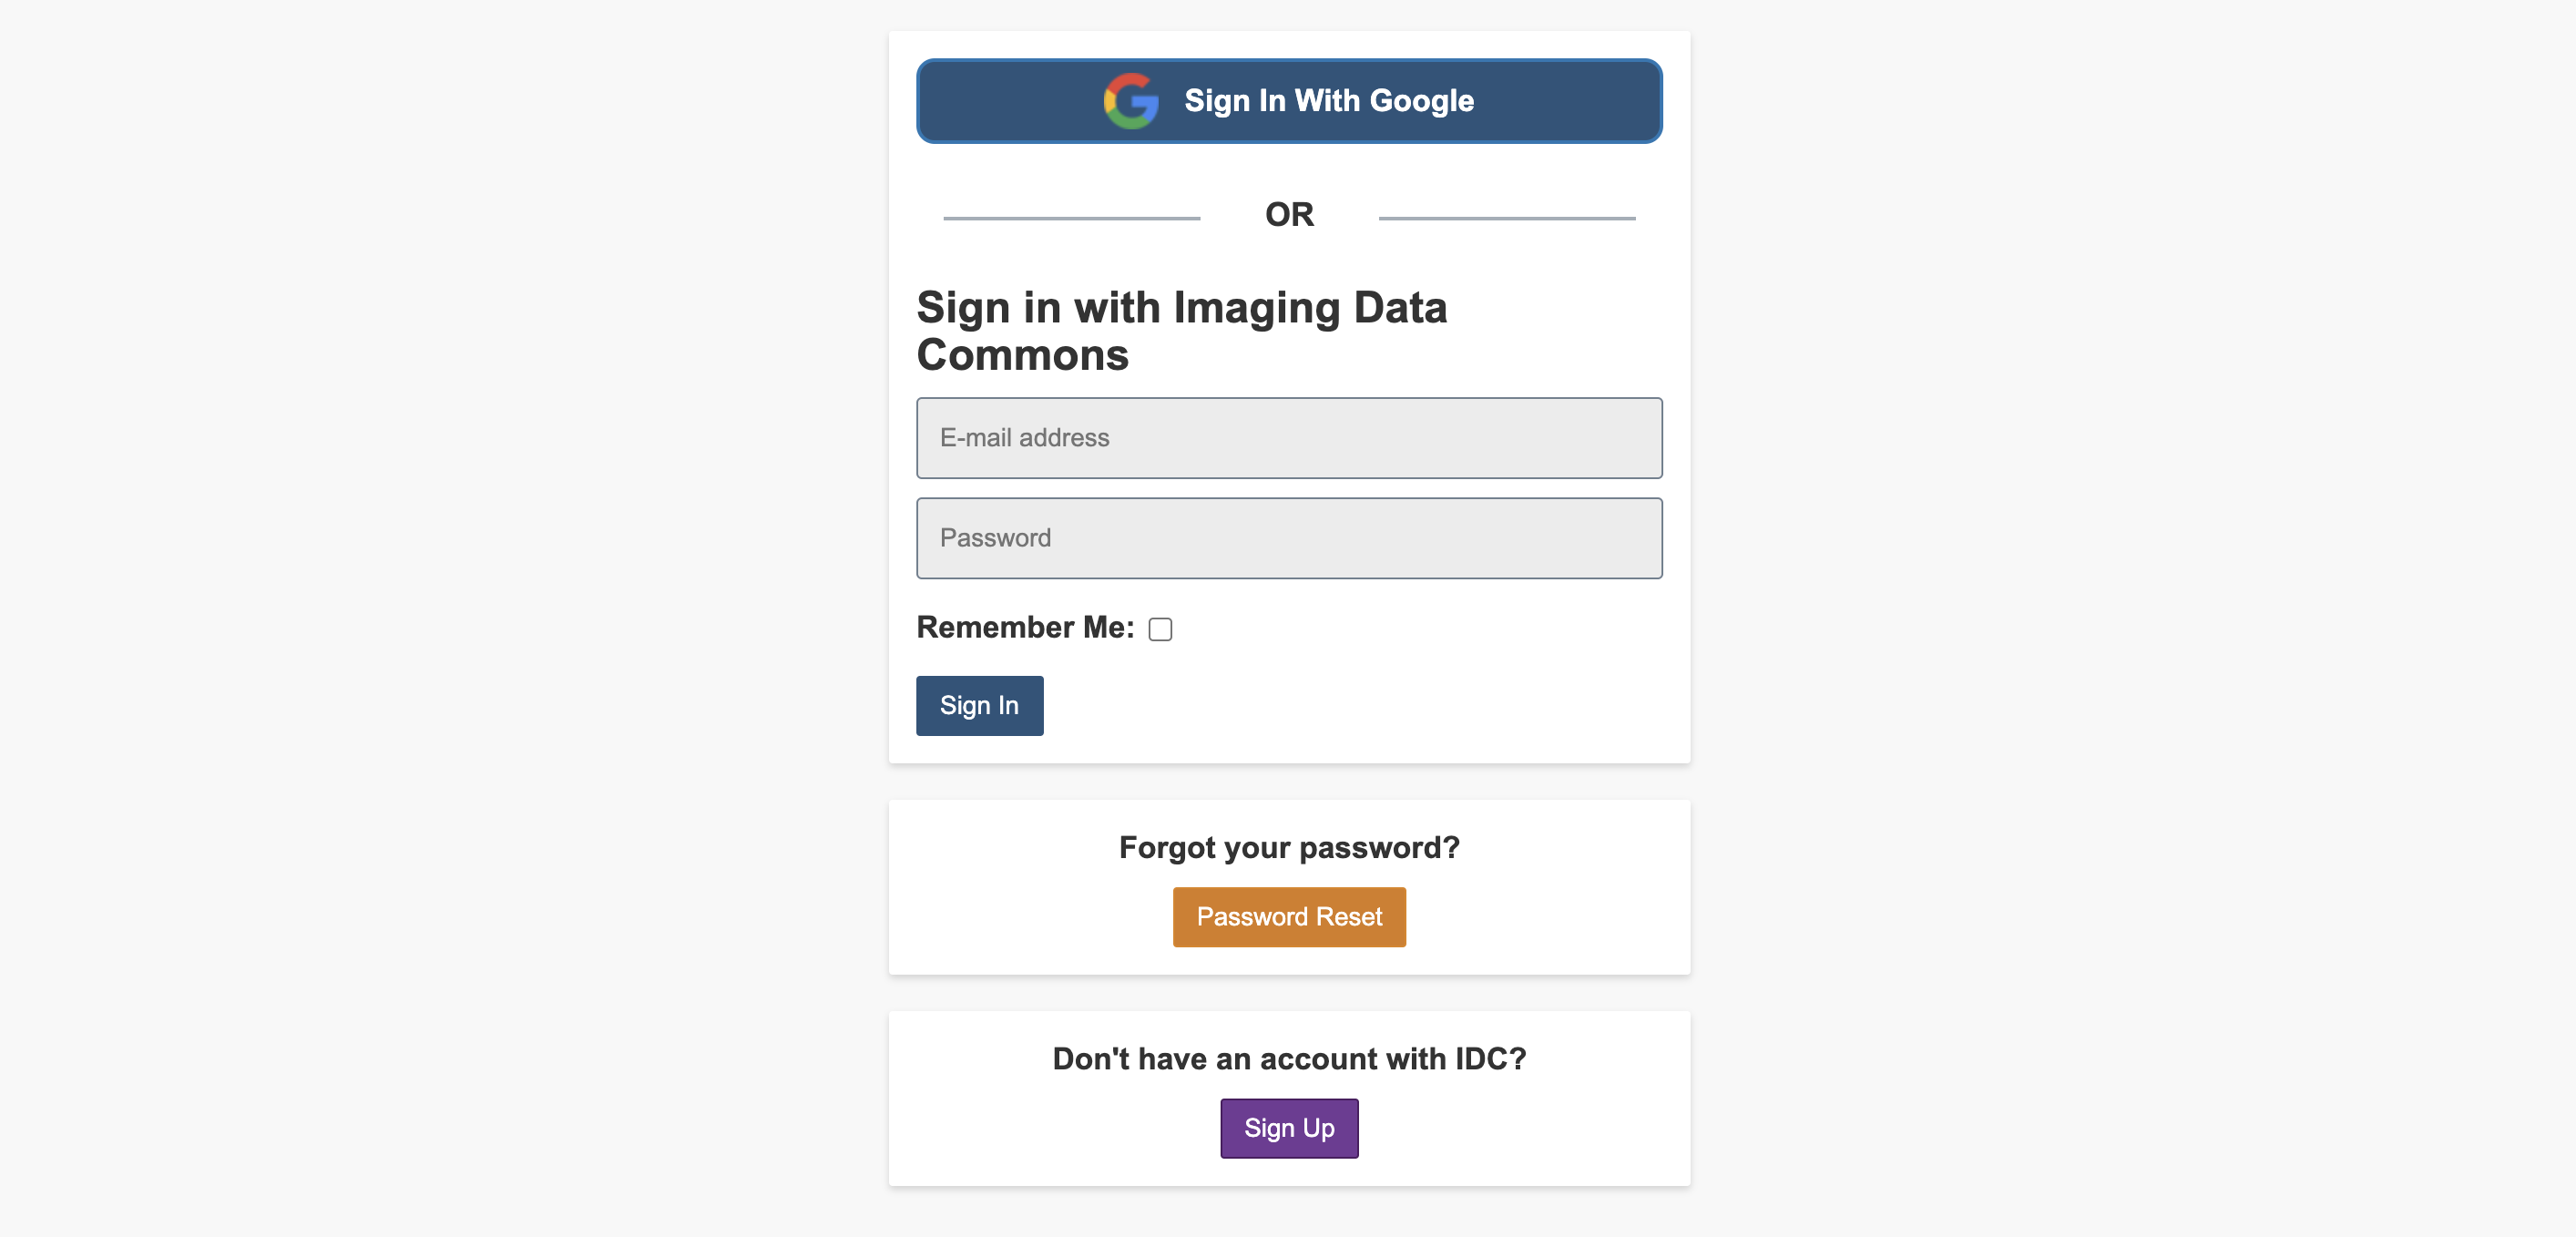

<br>

**To speed up the AI Image Processing pipelines, make sure the Colab Instance you are using is equipped with a GPU.**

You can check by clicking on "Runtime" in the menu bar, then selecting "Change Runtime Type" and making sure "GPU" is selected as Hardware acceleration. Colab GPUs include Nvidia K80s, T4s, P4s and P100s. As there is no way to choose what type of GPU you can connect to in Colab at any given time, processing times may vary.

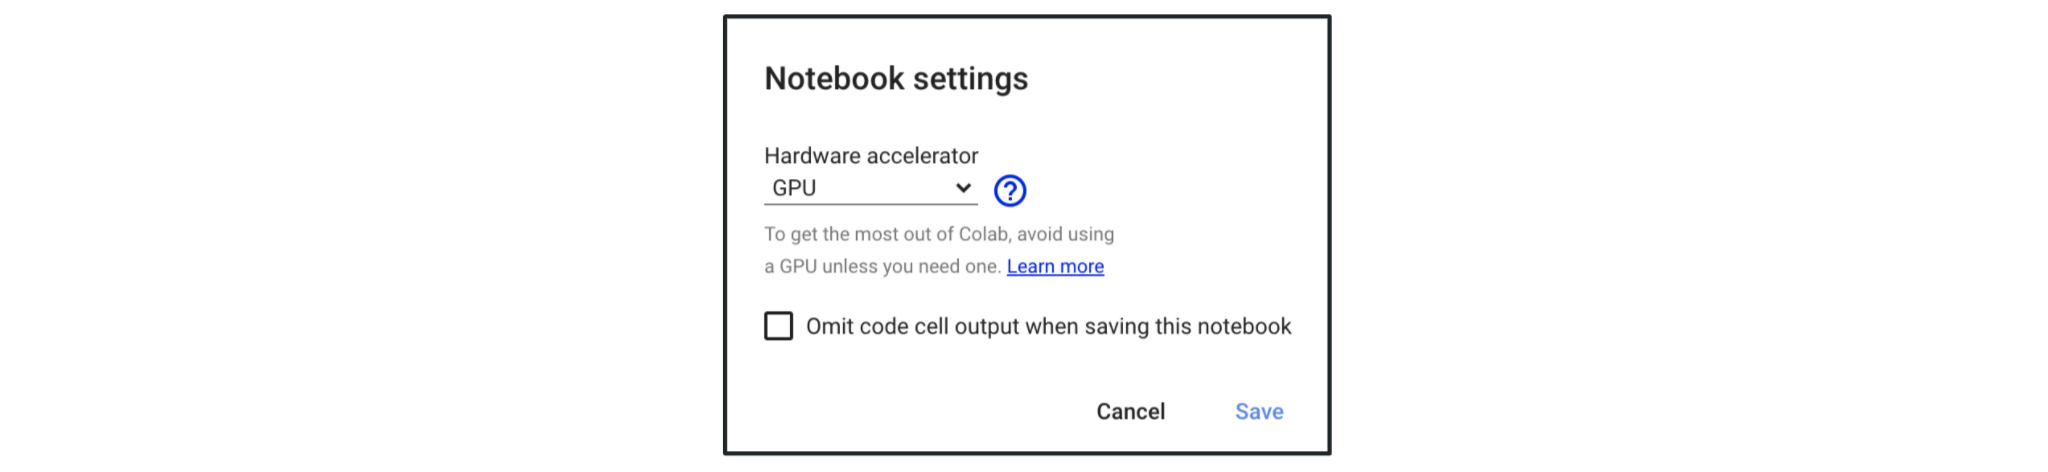

---

<br>

**In this notebook, we will test and end-to-end AI pipeline for lung nodule prognosis from CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.**

The AI pipeline is divided in two main steps. First, to automatically segment any lung nodule found in a chest CT scan, we will use one of the pre-trained models shared as part of the [nn-Unet model collection](https://www.nature.com/articles/s41592-020-01008-z). Second, to conduct the automatic lung nodule analysis we will use [DeepPrognosis](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002711), a Convolutional Neural Network trained to estimate a 2-year survival score starting from the segmentation mask of the nodule.

<br>

**The AI models deployed in this notebook have been trained on external and completely independent datasets from the IDC cohorts we are about to test them on.**

The idea behind this tutorial is therefore not to showcase a perfect AI-based processing pipeline, but rather investigate how IDC can help promoting transparency, reusability and reproducibility in AI - potentially accelerating the translation of these methods into clinical settings.


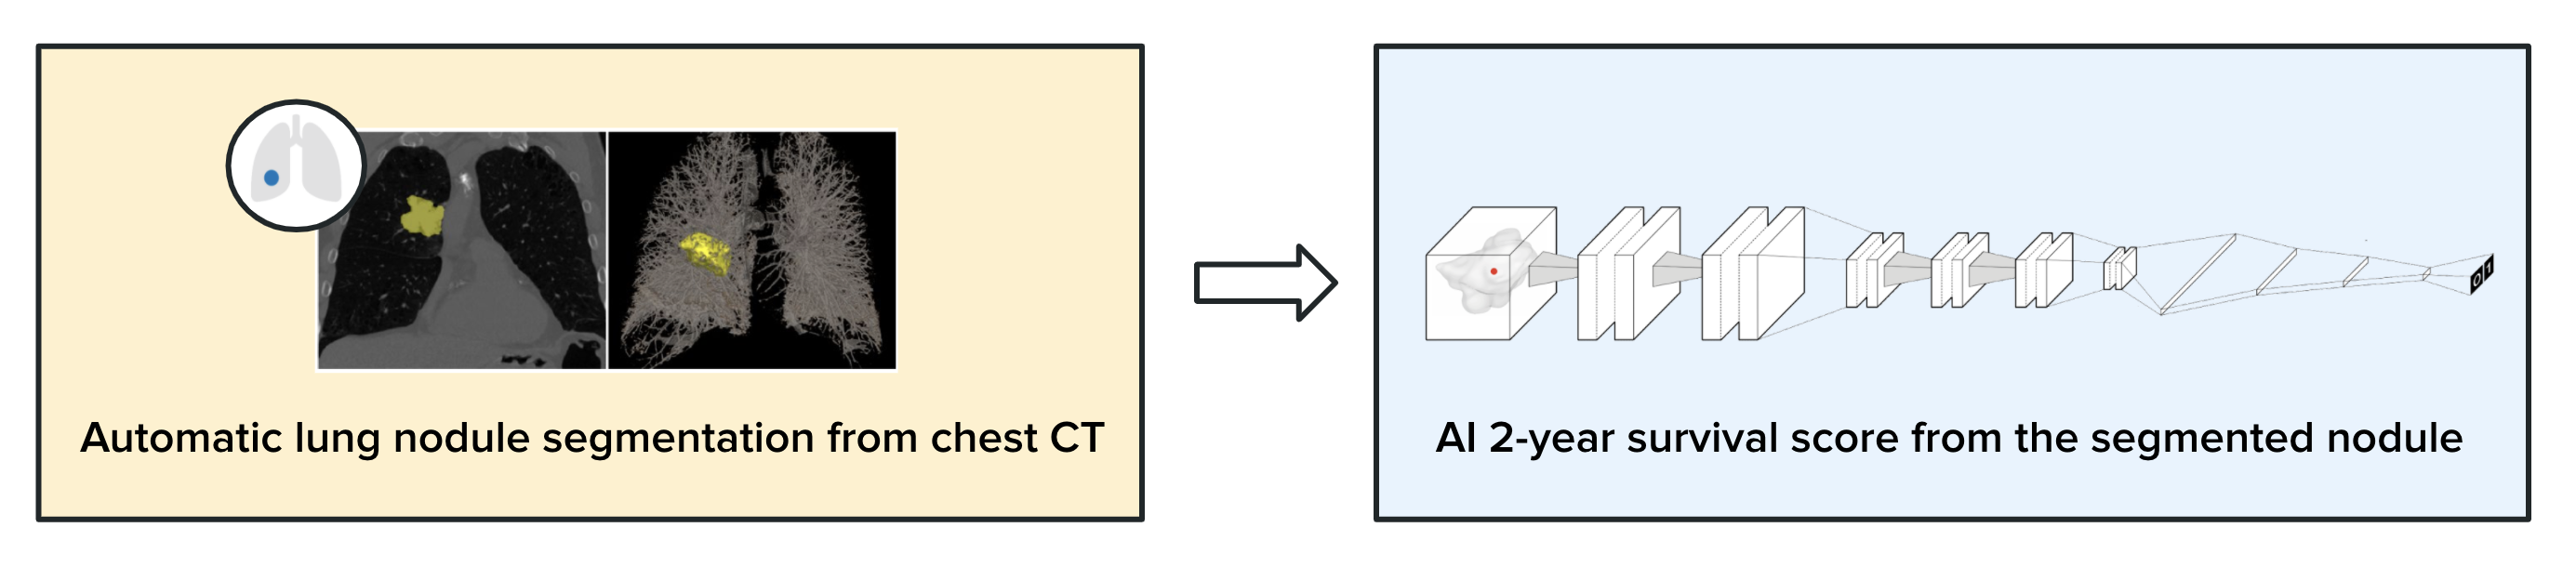

---

<br>

Since this demonstration runs in Google Colab, it highlights only a small part of what IDC can offer in terms of computational capability and imaging analysis: a more comprehensive experience of such tools can be explored, e.g., by experimenting with GCP Virtual Machines.

To learn more about how to access the GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

<br>

**Any questions, bugs to report, or feature you would like to see implemented in IDC?**

You are welcome to get in touch with us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


---

# Init & Imports

In order to access the IDC resources, the user must complete at first the Google authentication process.

To continue with the notebook, when prompted by the next code cell follow the generated link. After granting Google Cloud SDK access to the selected Google account, you will get a one-use login code. Copy the code, paste it in the blank space under the cell, and press enter to complete the authentication procedure.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# useful information
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /content
Hostname          : 0acde99c7de2
Username          : root


Before continuing with the notebook, we need to set-up the Google Colab environment by installing the Python and system dependencies the pre-processing and processing pipeline rely on.

## Python Dependencies

Install and import all the Python dependencies. 

The main python packages we need to install are:
* `nnunet` - which is the [codebase for the nn-UNet framework](https://github.com/MIC-DKFZ/nnUNet) we are going to be using for the segmentation step;
* `pydicom`, a Python [package](https://github.com/pydicom/pydicom) that lets the use read, modify, and write DICOM data in an easy "pythonic" way - that we are going to use to distinguish different DICOM objects from each other.

In [ ]:
%%capture
!pip install nnunet
!pip install pydicom

In [ ]:
# check wether the Colab Instance was correctly changed to a GPU instance
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "failed" in gpu_list[0] else True

In [ ]:
import os
import sys
import shutil

import time
import gdown

import json
import pprint
import numpy as np
import pandas as pd

import pydicom
import nibabel as nib
import SimpleITK as sitk

from medpy.metric.binary import dc as dice_coef
from medpy.filter.binary import largest_connected_component

# use the "tensorflow_version" magic to make sure TF 1.x is imported
%tensorflow_version 1.x
import tensorflow as tf
import keras

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)
print("TensorFlow version           : ", tf.__version__)
print("Keras (stand-alone) version  : ", keras.__version__)

print("\nThis Colab instance is equipped with a GPU.")

# ----------------------------------------

#everything that has to do with plotting goes here below
import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

## ----------------------------------------

import seaborn as sns

TensorFlow 1.x selected.
Python version               :  3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy version                :  1.19.5
TensorFlow version           :  1.15.2
Keras (stand-alone) version  :  2.3.1

This Colab instance is equipped with a GPU.


Using TensorFlow backend.


In [ ]:
# check which model of GPU the notebook is equipped with - a Tesla K80 or T4
# T4 is the best performing on the two - and can about half the GPU processing time

!nvidia-smi

Fri Aug 13 14:01:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Dependencies

Install all the system dependencies. 

Additional tutorial information (e.g., about Plastimatch) and links here.

In [ ]:
%%capture
!sudo apt update

!sudo apt install subversion
!sudo apt install plastimatch

In [ ]:
!echo $(plastimatch --version)
!echo $(svn --version | head -n 2)

plastimatch version 1.7.0
svn, version 1.9.7 (r1800392) compiled Mar 28 2018, 08:49:13 on x86_64-pc-linux-gnu


## Environment Setup

Set up the Linux environment variables needed to run the nnU-Net pipeline.

Additional tutorial information (e.g., what do the different variables mean etc.) and links (documentation) here.

In [ ]:
# set env variables for the bash process
os.environ['nnUNet_raw_data_base'] = "/content/tutorial/data/nnUNet_raw_data/"
os.environ['nnUNet_preprocessed'] = "/content/tutorial/data/preproc/"

os.environ["RESULTS_FOLDER"] = "/content/tutorial/output/"
os.environ["PATH_TO_MODEL_FILE"] = "/content/tutorial/models/Task006_Lung.zip"

---

# Models Download


## Lung Nodules Segmentation Model

Download the nnU-Net pre-trained model from a publicly shared Dropbox folder (way faster with respect to curl/wget from Zenodo, and doesn't have quota problems like Google Drive).

In [ ]:
# create the directory tree
!mkdir -p tutorial 
!mkdir -p tutorial/models tutorial/data tutorial/output
!mkdir -p tutorial/data/tmp tutorial/data/dicom tutorial/data/preproc tutorial/data/nnUNet_raw_data

In [ ]:
# Dropbox can actually be MUCH faster - about 3x, depends on how busy Google and Dropbox servers are, I guess!
seg_model_url = "https://www.dropbox.com/s/4ajcm2rvd8z40f1/Task006_Lung.zip?dl=0"
output_path = "tutorial/models/Task006_Lung.zip"

!wget -O $output_path $seg_model_url

--2021-08-13 14:01:56--  https://www.dropbox.com/s/4ajcm2rvd8z40f1/Task006_Lung.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4ajcm2rvd8z40f1/Task006_Lung.zip [following]
--2021-08-13 14:01:57--  https://www.dropbox.com/s/raw/4ajcm2rvd8z40f1/Task006_Lung.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d81a23c4114df10d9c630a149.dl.dropboxusercontent.com/cd/0/inline/BULdRI-Ed4ZLQnvtEdv2lyOtfFttfJKthDHrN1c7jGGi4gJIuYh4GLXSw6EOAcN3lPzIj0Mo2y0WmvLU2kRXdIxxaEU-pjb904yTEoHbgnzKk3SCbBWYT_27g_wpYg0FiRAzLPx6Mk0Sr-EK-uSC6gfv/file# [following]
--2021-08-13 14:01:58--  https://uc1d81a23c4114df10d9c630a149.dl.dropboxusercontent.com/cd/0/inline/BULdRI-Ed4ZLQnvtEdv2lyOtfFttfJKthDHrN1c7jGGi4gJIuYh4GLXSw6EOAcN3lPzIj0

Unpack and install model (under `PATH_TO_MODEL_FILE`).

In [ ]:
%%capture
!nnUNet_install_pretrained_model_from_zip $PATH_TO_MODEL_FILE

## Lung Nodules Prognosis Model

Download the DeepPrognosis pre-trained model from a publicly shared Dropbox folder.

In [ ]:
# FIXME: move to dropbox as well
prognosis_model_weights_url = "https://www.dropbox.com/s/brhu1j9dq0d5rry/weights.h5?dl=0"
output_path = "tutorial/models/dp_weights.h5"

!wget -O $output_path $prognosis_model_weights_url

# ----------------------------------------
# FIXME: move to dropbox as well
prognosis_model_arch_url = "https://www.dropbox.com/s/f7flnqltxvyxg3b/architecture.json?dl=0"
output_path = "tutorial/models/dp_arch.json"

!wget -O $output_path $prognosis_model_arch_url

--2021-08-13 14:08:56--  https://www.dropbox.com/s/brhu1j9dq0d5rry/weights.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/brhu1j9dq0d5rry/weights.h5 [following]
--2021-08-13 14:08:56--  https://www.dropbox.com/s/raw/brhu1j9dq0d5rry/weights.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca8e72bbee510a0d753ad0b2a2e.dl.dropboxusercontent.com/cd/0/inline/BUJE4dtOU0DfUxu4BjuMs8LHm_W_1fILWCfjPMg-h-2ytn53kFJleEBmP2wLv1dALEAfSeWvkby7vwwdSYW70haateSAZDbROw-9L-wF51pXBRg_sBplgdHF1uT8Y5P0FtPwio5oHsdk7hdJPaT91XHT/file# [following]
--2021-08-13 14:08:57--  https://uca8e72bbee510a0d753ad0b2a2e.dl.dropboxusercontent.com/cd/0/inline/BUJE4dtOU0DfUxu4BjuMs8LHm_W_1fILWCfjPMg-h-2ytn53kFJleEBmP2wLv1dALEAfSeWvkby7vwwdSYW70haateS

---

# Cohort Download

In this tutorial, we will test and end-to-end AI pipeline for lung nodule prognosis from CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.

The NSCLC-Radiomics cohort contains images from stage I–IIIb NSCLC patients imaged with CT, with or without intravenous contrast, and treated with radiation therapy at MAASTRO Clinic, Maastricht, The Netherlands. Images were acquired between 2004 and 2010. For these patients pretreatment CT scans, manual delineation by a radiation oncologist of the 3D volume of the gross tumor volume and clinical outcome data are available. This dataset refers to the Lung1 dataset in [Aerts et Al. - Decoding tumour phenotype by noninvasive imaging using a quantitative radiomics approach](https://www.nature.com/articles/ncomms5006), (Nature Communications, 2014).

<br>

The Imaging Data Commons GCS buckets are "[requester pays](https://cloud.google.com/storage/docs/requester-pays)" buckets. Hence, it is not possible to [mount such buckets directly in Colab](https://gist.github.com/korakot/f3600576720206363c734eca5f302e38).

Instead, what the user can do is to query the BigQuery table associated to the bucket/dataset, select the cohort of interest, and then download the files exploiting `gsutil`. This cohort selection operation can be done through the graphic user interface at the [IDC Portal](https://portal.imaging.datacommons.cancer.gov/).

On the main page of the portal, click on "Lung" to browse all the data related to that site.

IDC_lung_click.png

In the "Search Configuration" box on the leff, click on "Derived" and then "Segmentation" to browse by the segmentation data available.

exploration_click.png

Under "Segmentation Type", choose "Neoplasm; Primary (SCT)" to browse all the patients for which that information is available (and therefore, patients that have lung lesions we can process with the AI pipeline). 

nodules_click.png

After logging in, (e.g., sign In with your Google Account) you will be able to save the selected cohort by clicking on "Save as New Cohort". After choosing a name and a description, click on the same button which has not became "Export Cohort Manifest".

<br>

**N.B.**: in general, the data can be downloaded from IDC either using directly the manifest (the "not recommended" approach - generate GCS URIs from the manifest itself) or exploiting BigQuery queries. See this [cohort download notebook](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/Cohort_download.ipynb) to learn more about the process.

In this Notebook, we will exploit BigQuery tables to fetch the data from the IDC buckets (the "recommended" approach).

save_cohort.png

After clicking the "Export Cohort Manifest" button, when prompted, select "BigQuery" in the dialog box. The portal will now generate the correspondend BigQuery table: once that is done, follow the link to the Google Cloud Computing platform and click on "Query" in the cohort manifest panel. You can copy the content of the query in the next code cell (and remove the `LIMIT 1000` at the end) and procede with the notebook. 

query.png

In [ ]:
# we should put in a couple of links/screenshots on how to create GCP project
# (since it takes one minute and it's completely free)
%%bigquery --project=idc-sandbox-000 cohort_df
SELECT * FROM `canceridc-user-data.user_manifests.manifest_cohort_222_20210811_071925`

In [ ]:
cohort_df.head()

PatientID  ...                                            gcs_url
0  LUNG1-312  ...  gs://idc-open/92d8d7fd-31e8-4570-be42-7c005c0d...
1  LUNG1-079  ...  gs://idc-open/c141a2ff-7e32-41d3-b8fe-ddfd4e62...
2  LUNG1-044  ...  gs://idc-open/5d388d3d-38f0-46e9-aaec-6a8a1070...
3  LUNG1-094  ...  gs://idc-open/8c9e6457-0217-45b9-9cbc-b680e353...
4  LUNG1-018  ...  gs://idc-open/8dd0f9f7-b1b9-4ce1-a615-149c67c0...

[5 rows x 10 columns]

In [ ]:
gs_file_path = "tutorial/data/gcs_paths.txt"

pat = "LUNG1-007"
sliced_df = cohort_df[cohort_df["PatientID"] == pat]

sliced_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

In [ ]:
%%capture
# https://cloud.google.com/storage/docs/gsutil/commands/cp
!mkdir -p tutorial/data/tmp
!cat $gs_file_path | gsutil -u idc-sandbox-000 -m cp -Ir tutorial/data/tmp

To carry out some of the operations [...]

* DICOMSort - a tool for custom sorting and renaming of dicom files;
* PyPlastimatch - a very basic python wrapper for Plastimatch. 

In [ ]:
# DICOMSORT - for re-ordering DICOM files in folders
!git clone https://github.com/pieper/dicomsort.git tutorial/dicomsort

# PyPlastimatch - python wrapper for Plastimatch (and interactive notebook visualisation)
!git clone https://github.com/denbonte/pyplastimatch.git tutorial/pyplastimatch

Cloning into 'tutorial/dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 631.00 KiB/s, done.
Resolving deltas: 100% (63/63), done.
Cloning into 'tutorial/pyplastimatch'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 4), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [ ]:
!python tutorial/dicomsort/dicomsort.py -u tutorial/data/tmp tutorial/data/dicom/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
!rm -r tutorial/data/tmp

100% 131/131 [00:01<00:00, 118.63it/s]
Files sorted


---

# Data Pre-processing

First, download a dummy python Plastimatch wrapper that will make our life easier (optional?).

In [ ]:
from tutorial.pyplastimatch.pyplastimatch import pyplastimatch as pypla
from tutorial.pyplastimatch.pyplastimatch import viz_utils as viz_utils

Preprocess the data. Convert the DICOM CT and RTSTRUCT to NRRD (easier handling), and the former to NIfTI ( nnU-Net processing) as well.

Start by simply identifying what is the `SeriesInstanceUID` associated with DICOM CT, RTSTRUCT and RTSEG.

In [ ]:
StudyInstanceUID = sliced_df["StudyInstanceUID"].values[0]
SeriesInstanceUID_list = sliced_df["SeriesInstanceUID"].values

SeriesInstanceUID_unique = list(np.unique(SeriesInstanceUID_list))

for SeriesInstanceUID in SeriesInstanceUID_unique:
  if len([x for x in SeriesInstanceUID_list if x == SeriesInstanceUID]) > 1:
    SeriesInstanceUID_ct = SeriesInstanceUID

SeriesInstanceUID_unique.remove(SeriesInstanceUID_ct)

In [ ]:
for SeriesInstanceUID in SeriesInstanceUID_unique:
  path_to_dcm_folder = os.path.join("tutorial/data/dicom", pat, StudyInstanceUID, SeriesInstanceUID)
  path_to_dcm_file = os.path.join(path_to_dcm_folder, os.listdir(path_to_dcm_folder)[0])

  if pydicom.dcmread(path_to_dcm_file).Modality == "SEG":
    SeriesInstanceUID_seg = SeriesInstanceUID
  
  if pydicom.dcmread(path_to_dcm_file).Modality == "RTSTRUCT":
    SeriesInstanceUID_rt = SeriesInstanceUID

## DICOM to NRRD/NIfTI Conversion

In [ ]:
# directories storing NRRD and NIfTI files
base_preproc_path = "tutorial/data/preproc"

pat_dir_path_nrrd = os.path.join(base_preproc_path, "nrrd", pat)
pat_dir_path_nii = os.path.join(base_preproc_path, "nii", pat)
  
# patient subfolder where all the preprocessed NRRDs will be stored
if not os.path.exists(pat_dir_path_nrrd): os.makedirs(pat_dir_path_nrrd)
  
# patient subfolder where all the preprocessed NIfTIs will be stored
if not os.path.exists(pat_dir_path_nii): os.makedirs(pat_dir_path_nii)

# path to the directory where the DICOM CT file is stored
path_to_ct_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_ct)

# path to the files where the NRRD and NIfTI CTs will be stored
ct_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_ct.nrrd")
ct_nii_path = os.path.join(pat_dir_path_nii, pat + "_ct.nii.gz")


# path to the directory where the DICOM RTSTRUCT file is stored
path_to_rt_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_rt)

# path to the files where the NRRD RTSTRUCTs will be stored
rt_folder = os.path.join(pat_dir_path_nrrd, "RTSTRUCT")
rt_list_path = os.path.join(pat_dir_path_nrrd, "RTSTRUCT_content")

verbose = True

# logfile for the plastimatch conversion
log_file_path_nrrd = os.path.join(pat_dir_path_nrrd, pat + '_pypla.log')
log_file_path_nii = os.path.join(pat_dir_path_nii, pat + '_pypla.log')
  
# DICOM CT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nrrd_path):
  convert_args_ct = {"input" : path_to_ct_dir,
                      "output-img" : ct_nrrd_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)

# DICOM RTSTRUCT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(rt_folder):
  convert_args_rt = {"input" : path_to_rt_dir, 
                      "referenced-ct" : path_to_ct_dir,
                      "output-prefix" : rt_folder,
                      "prefix-format" : 'nrrd',
                      "output-ss-list" : rt_list_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_rt)

# DICOM CT to NIfTI conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nii_path):
  convert_args_nii = {"input" : path_to_ct_dir, 
                      "output-img" : ct_nii_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nii): os.remove(log_file_path_nii)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.32722.99.99.282967364651788470277412461462049836277/1.3.6.1.4.1.32722.99.99.234266984120913576066174046169649067872
  --output-img tutorial/data/preproc/nrrd/LUNG1-007/LUNG1-007_ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.32722.99.99.282967364651788470277412461462049836277/1.3.6.1.4.1.32722.99.99.308499776475237758781599767226383467358
  --referenced-ct tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.32722.99.99.282967364651788470277412461462049836277/1.3.6.1.4.1.32722.99.99.234266984120913576066174046169649067872
  --output-prefix tutorial/data/preproc/nrrd/LUNG1-007/RTSTRUCT
  --prefix-format nrrd
  --output-ss-list tutorial/data/preproc/nrrd/LUNG1-007/RTSTRUCT_content
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-007/1.3.6.1.4.1.327

In [ ]:
# create a folder (random task name) for nnU-Net inference
proc_folder_path = os.path.join(os.environ["nnUNet_raw_data_base"],
                                "nodule_seg", "imagesTs")

!mkdir -p $proc_folder_path

# populate the folder following the nnU-Net naming conventions
copy_path = os.path.join(proc_folder_path, pat + "_0000.nii.gz")

# copy NIfTI to the right dir for nnU-Net processing
# TODO: find a way to do this with symlinks to avoid useless redundance
# e.g., files in the nnU-Net dir, symlinks in the preproc/dataset/nii folder
if not os.path.exists(copy_path):
  shutil.copy(src = ct_nii_path, dst = copy_path)

---

# Lung Nodules Segmentation

Run the nnU-Net segmentation pipeline. Description of the different operations here.

## Data Processing

In [ ]:
# run the inference phase
# accepted options for --model are: 2d, 3d_lowres, 3d_fullres or 3d_cascade_fullres
!nnUNet_predict --input_folder "tutorial/data/nnUNet_raw_data/nodule_seg/imagesTs" \
                --output_folder $RESULTS_FOLDER \
                --task_name "Task006_Lung" --model 2d --disable_tta 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/tutorial/output/nnUNet/2d/Task006_Lung/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 1 unique case ids, here are some examples: ['LUNG1-007']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 1
number of cases that still need to be predicted: 1
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/content/tutorial/output/nnUNet/2d/Task006_Lung/nnUNetTrainerV2__nnUNetPlansv

## Data Post-processing

Conversion back to NRRD for visualisation purposes and for easier handling.

In [ ]:
pred_nii_path = os.path.join(os.environ["RESULTS_FOLDER"], pat + ".nii.gz")

sitk_ct = sitk.ReadImage(ct_nrrd_path)

nrrd_spacing = sitk_ct.GetSpacing()
nrrd_dim = sitk_ct.GetSize()

nii_spacing = tuple(nib.load(pred_nii_path).header['pixdim'][1:4])
nii_dim = tuple(nib.load(pred_nii_path).get_fdata().shape)

assert (nrrd_spacing == nii_spacing) & (nrrd_dim == nii_dim)

## ----------------------------------------
# NIfTI TO NRRD CONVERSION

# path to the output NRRD file (inferred segmasks)
pred_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_pred_gtv.nrrd")
log_file_path = os.path.join(pat_dir_path_nrrd, pat + "_pypla.log")

# Inferred NIfTI segmask to NRRD
convert_args_pred = {"input" : pred_nii_path, 
                     "output-img" : pred_nrrd_path}

pypla.convert(path_to_log_file = log_file_path, **convert_args_pred)


Running 'plastimatch convert' with the specified arguments:
  --input /content/tutorial/output/LUNG1-007.nii.gz
  --output-img tutorial/data/preproc/nrrd/LUNG1-007/LUNG1-007_pred_gtv.nrrd
... Done.


## Visualising the Segmentation Masks

In [ ]:
# load NRRD volumes
ct_nrrd = sitk.GetArrayFromImage(sitk_ct)

# inferred segmask
pred_nrrd_gtv = sitk.GetArrayFromImage(sitk.ReadImage(pred_nrrd_path))

# manual segmask (from the RTSTRUCT)
rt_segmasks = os.path.join(pat_dir_path_nrrd, "RTSTRUCT", "GTV-1.nrrd")
rt_nrrd_gtv = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmasks))

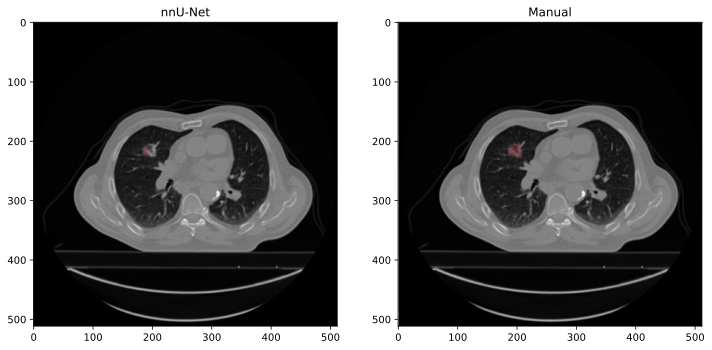

In [ ]:
_ = viz_utils.AxialSliceSegmaskComparison(ct_volume = ct_nrrd,
                                          segmask_ai_dict = {"GTV" : pred_nrrd_gtv},
                                          segmask_manual_dict = {"GTV" : rt_nrrd_gtv},
                                          segmask_cmap_dict = {"GTV" : my_reds},
                                          dpi = 100)

## Quantitative Performance

In [ ]:
# dice coefficient/whatever could go here

In [ ]:
# largest connected component analysis

---

# Lung Nodule Prognosis Score

After creating lung nodules have been segmented exploiting the nnU-Net pipeline, we can leverage another AI model to assign a prognosis score to each of the patients looking at the lesions.

For this, we make use of an AI model developed and validated in [Hosny et Al. - Deep learning for lung cancer prognostication: A retrospective multi-cohort radiomics study](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002711) (PLOS Medicine, 2018). The model comprises a total of four 3D convolutional layers of an increasing number of filters, and two max pooling layers (after the second and fourth convolutional layers). The head of the model is a series of four fully connected layers which provide high-level reasoning before the prediction probabilities are calculated in the final softmax classifier layer. 

Additional details regarding the model development, architectural choices and training can be found in the PLOS Medicine paper.

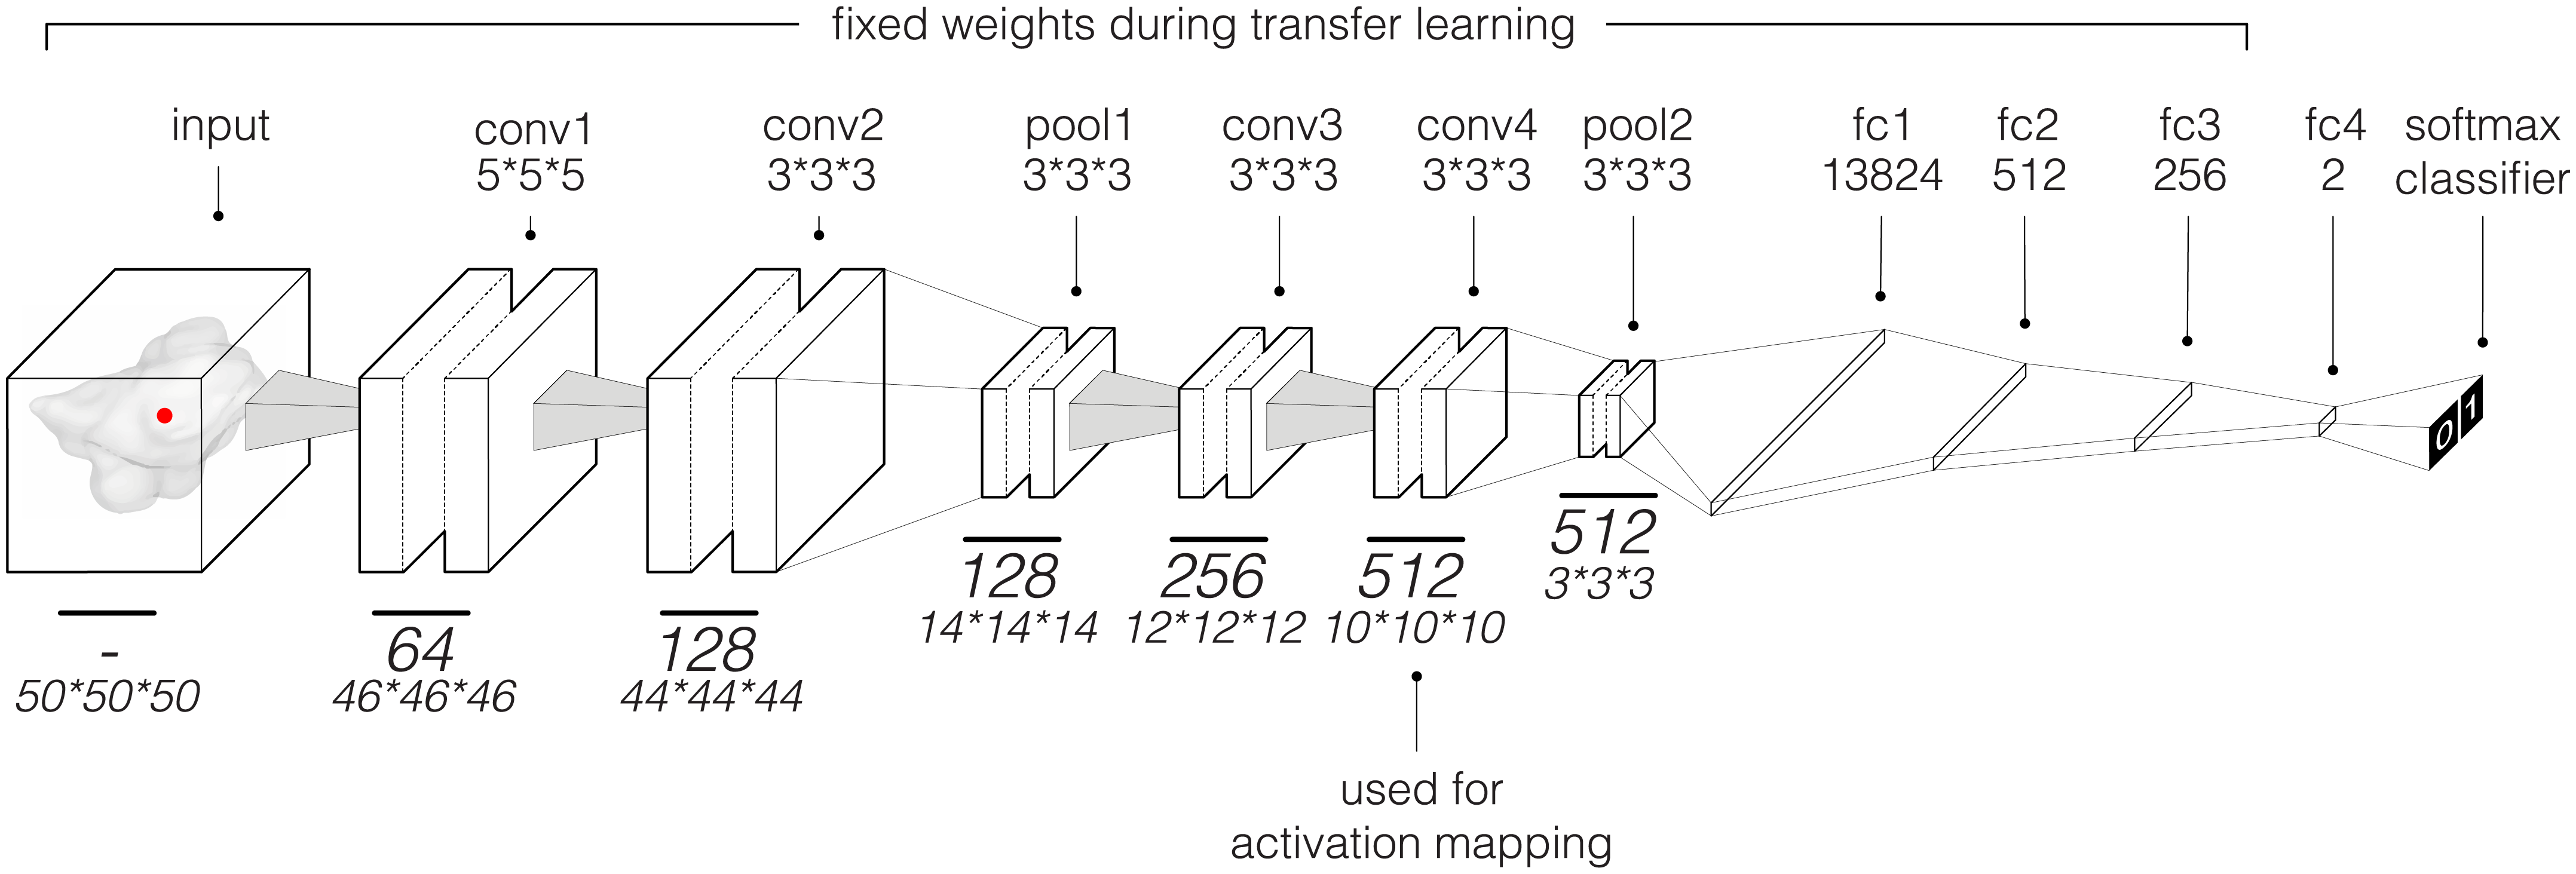

The prognosis model expects as an input a small $50 \times 50 \times 50$ volume cropped around the center of mass of the lung lesion. Furthermore, the intensity values of such volume need to be normalised between $0$ and $1$.

Let's start by defining a couple of very simple functions that we will use to make the input data fit to the AI model (and keep the following code cells easier to read): one for the computation of the center of mass (starting from the segmentation mask we computed in the previous sections), and the other for the intensity normalisation.

In [ ]:
# FIXME: move to a python script?
# FIXME: actually install pyradiomics?
# adapted from https://github.com/AIM-Harvard/pyradiomics/blob/master/radiomics/generalinfo.py
def getCenterOfMassIndexValue(input_mask):
    
    """
    Returns z, y and x coordinates of the center of mass of the ROI in terms of
    the image coordinate space (continuous index).

    Calculation is based on the original (non-resampled) mask.
    Because this represents the continuous index, the order of x, y and z is reversed,
    i.e. the first element is the z index, the second the y index and the last element is the x index.

    @params:
      input_mask - required : numpy (binary) volume storing the segmentation mask.

    """

    if input_mask is not None:
      mask_coordinates = np.array(np.where(input_mask == 1))
      center_index = np.mean(mask_coordinates, axis = 1)
      return tuple(center_index)
    else:
      return None

## ----------------------------------------
## ----------------------------------------

# normalise the values of the volume between new_min_val and new_max_val
def normaliseVolume(input_volume, new_min_val, new_max_val, old_min_val = None, old_max_val = None):

  """
  Normalise a numpy volume intensity in a range between two given values
  
  @params:
    input_volume - required : numpy volume to rescale (intensity-wise) in the new range.
    new_min_val  - required : the lower bound of the new intensity range.
    new_max_val  - required : the upper bound of the new intensity range.
    old_min_val  - optional : the lower bound of the old intensity range. Defaults to input_volume's np.min()
    old_max_val  - optional : the lower bound of the old intensity range. Defaults to input_volume's np.max()
    
  """
  
  # make sure the input volume is treated as a float volume
  input_volume = input_volume.astype(dtype = np.float16)

  # if no old_min_val and/or old_max_val are specified, default to the np.min() and np.max() of input_volume
  
  curr_min = np.min(input_volume) if old_min_val == None else old_min_val
  curr_max = np.max(input_volume) if old_max_val == None else old_max_val


  # normalise the values of each voxel between zero and one
  zero_to_one_norm = (input_volume - curr_min)/(curr_max - curr_min)

  # normalise between new_min_val and new_max_val
  return (new_max_val - new_min_val)*zero_to_one_norm + new_min_val

## Data Processing


Description.


In [ ]:
%%capture
model_base_path = "tutorial/models"

arch_json_path = os.path.join(model_base_path, "dp_arch.json")
weights_path = os.path.join(model_base_path, "dp_weights.h5")

"""
 N.B. any warnings are due to the fact that the model was developed for
 Keras 1, and the config file has been converted in a Keras-2-compatible file

 Nonetheless, Keras 2 uses different naming conventions/def.s, so in order to
 get rid of the warnings one should change all the layers def.s in the JSON file
"""

# load the model architecture from the config file, then load the model weights 
with open(arch_json_path, 'r') as json_file:
    model_json = json.load(json_file)  

model = keras.models.model_from_config(model_json)
model.load_weights(weights_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# compute the center of mass of the inferred lung nodule segmentation mask 
pred_com = np.array(getCenterOfMassIndexValue(pred_nrrd_gtv))
pred_com_int = np.ceil(pred_com).astype(dtype = np.uint16)

# compute the center of mass of the manual lung nodule segmentation mask
a = largest_connected_component(pred_nrrd_gtv)*pred_nrrd_gtv
a_com = np.array(getCenterOfMassIndexValue(a))
a_com_int = np.ceil(a_com).astype(dtype = np.uint16)

In [ ]:
# compute the center of mass of the inferred lung nodule segmentation mask 
pred_com = np.array(getCenterOfMassIndexValue(pred_nrrd_gtv))
pred_com_int = np.ceil(pred_com).astype(dtype = np.uint16)

# same, but keeping only largest connected component (under the hypothesis that is the GTV) 
pred_nrrd_gtv_lcc = largest_connected_component(pred_nrrd_gtv)*pred_nrrd_gtv
pred_lcc_com = np.array(getCenterOfMassIndexValue(pred_nrrd_gtv_lcc))
pred_lcc_com_int = np.ceil(pred_lcc_com).astype(dtype = np.uint16)

# compute the center of mass of the manual lung nodule segmentation mask
rt_com = np.array(getCenterOfMassIndexValue(rt_nrrd_gtv))
rt_com_int = np.ceil(rt_com).astype(dtype = np.uint16)

print("CoM - inferred (raw) : ", pred_com)
print("CoM - inferred + LCC : ", pred_lcc_com)
print("CoM - manual segmask : ", rt_com)

CoM - inferred (raw) :  [ 57.9783105  220.44748858 194.8348554 ]
CoM - inferred + LCC :  [ 55.8942226  215.20093458 197.96304163]
CoM - manual segmask :  [ 54.79230593 216.2489123  198.38653538]


In [ ]:
input_volume = ct_nrrd[rt_com_int[0]-25 : rt_com_int[0]+25,
                       rt_com_int[1]-25 : rt_com_int[1]+25,
                       rt_com_int[2]-25 : rt_com_int[2]+25]

input_volume = normaliseVolume(input_volume = input_volume,
                               new_min_val = 0., new_max_val = 1.)

input_volume = np.expand_dims(input_volume, axis = 0)
input_volume = np.expand_dims(input_volume, axis = -1)
    
# 2 yrs survival score is logit 1; N.B. - this is not the survival probability!
# The model stratifies patients well, but does not provide that kind of information
y_pred_raw = model.predict(input_volume)

pat_dict = dict()
pat_dict["PatientID"] = pat
pat_dict["path_to_nrrd"] = ct_nrrd_path
pat_dict["surv_score_manual_seg"] = y_pred_raw[0, 1]

## ----------------------------------------

input_volume = ct_nrrd[pred_lcc_com_int[0]-25 : pred_lcc_com_int[0]+25,
                       pred_lcc_com_int[1]-25 : pred_lcc_com_int[1]+25,
                       pred_lcc_com_int[2]-25 : pred_lcc_com_int[2]+25]

input_volume = normaliseVolume(input_volume = input_volume,
                               new_min_val = 0., new_max_val = 1.)

input_volume = np.expand_dims(input_volume, axis = 0)
input_volume = np.expand_dims(input_volume, axis = -1)
    
# 2 yrs survival score is logit 1; N.B. - this is not the survival probability!
# The model stratifies patients well, but does not provide that kind of information
y_pred_raw = model.predict(input_volume)

pat_dict["surv_score_AI_seg"] = y_pred_raw[0, 1]

In [ ]:
res_df = pd.DataFrame()
processed_pat_list = list()
    
res_df = res_df.append(pat_dict, ignore_index = True)

res_df

PatientID  ... surv_score_manual_seg
0  LUNG1-007  ...              0.997224

[1 rows x 4 columns]